In [1]:
import ROOT
import pandas as pd
import numpy as np
from numpy.linalg import inv


## Load wafer traces

In [2]:
dir_root = "/home/mijail/python_projects/CMS TPG/"
cellMap = "input_files/v16.5/WaferCellMapTraces.txt"
modMap = "input_files/v16.5/geometry.16.5.txt"
sipmMap = "input_files/v16.5/channels_sipmontile.hgcal.txt"

In [3]:
def read_tsv(dir:str)->pd.DataFrame:
    with open(dir,'r') as file:
        firstline = True
        dic_df = {}
        for line in file.readlines():
            line_list_raw = line.split(' ') # Separates the values and deletes the new line char
            line_list = [x for x in line_list_raw if x not in ('','\n')] # Removes empty strings nad new line for safe measure
            if firstline:
                firstline = False
                cols = line_list.copy()
                for col in cols: dic_df[col] = []
            else:
                assert len(cols) == len(line_list), (len(dic_df[cols[0]]),line_list)
                for i,entry in enumerate(line_list): dic_df[cols[i]].append(entry)
    return pd.DataFrame(dic_df)

In [4]:
sipmDF = read_tsv(dir_root+sipmMap)
moduleTypes = sipmDF['Typecode'].unique()
moduleTypes

array(['TM-A5A6', 'TM-B11B12', 'TM-B12', 'TM-C5', 'TM-D8', 'TM-E8',
       'TM-G3', 'TM-G4', 'TM-G5', 'TM-G6', 'TM-G7', 'TM-G8', 'TM-J8',
       'TM-K4', 'TM-K6', 'TM-K7'], dtype=object)

In [5]:

with open(dir_root+cellMap,'r') as file:
    firstline=True
    dic_df = {}
    for line in file.readlines(): #Vertical Loop
        linelistraw = line[:-1].split(' ') # Removes the new line character
        linelist = [x for x in linelistraw if not (x in ['','\n'])] #Removes all the empty strings from the list
        if firstline:
            cols = linelist.copy()
            for col in cols: dic_df[col] = []
            firstline=False
        else: 
            for i,entry in enumerate(linelist): dic_df[cols[i]].append(entry)

cellDF = pd.DataFrame(dic_df)        
moduleTypes = cellDF['Typecode'].unique()
moduleTypes


array(['ML-F', 'MH-F', 'ML-T', 'ML-B', 'ML-L', 'ML-R', 'ML-5', 'MH-T',
       'MH-B', 'MH-L', 'MH-R'], dtype=object)

In [6]:
cellDF['iu'].unique(),cellDF['iv'].unique()

(array(['3', '2', '0', '1', '-1', '4', '5', '6', '7', '12', '13', '11',
        '14', '15', '10', '9', '8', '20', '18', '19', '21', '23', '22',
        '16', '17'], dtype=object),
 array(['7', '6', '-1', '5', '4', '3', '2', '1', '0', '12', '13', '14',
        '15', '10', '11', '9', '8', '16', '17', '18', '19', '21', '20',
        '22', '23'], dtype=object))

In [7]:
MHL = cellDF[cellDF['Typecode']=='MH-L']
u=MHL['iu'].to_numpy(dtype=np.float64)
v=MHL['iv'].to_numpy(dtype=np.float64)
u,v

(array([13., 13., 13., 13., 14., 14., 14., 14., 13., 12., 13., 12., 13.,
        14., 13., 14., 12., 14., 15., 16., 16., 15., 15., 17., 17., 16.,
        15., 17., 18., 18., 18., 19., 20., 20., 20., 19., 19., 19., 21.,
        22., 18., 19., 20., 18., 20., 18., 16., 16., 17., 17., 17., 16.,
        15., 15., 15., 21., 23., 22., 22., 23., 21., 21., 23., 21., 22.,
        15., 14., 16., -1., -1., -1., -1., -1., -1., 12., 11., 12., 12.,
        11., 10., 10., 11., 10., 12., 11., 12., 12., 10., 10.,  8., 11.,
         9.,  2.,  8.,  8.,  9.,  9.,  8.,  9.,  7.,  7.,  7.,  6.,  5.,
         6.,  4.,  6.,  3.,  2.,  4.,  5., 10., 11., 11., 11.,  9.,  9.,
        10.,  9., 10.,  7.,  8.,  8.,  8.,  6.,  7.,  6.,  7.,  6.,  8.,
         3.,  4.,  3.,  4.,  5.,  3.,  5.,  5.,  4.,  0.,  2.,  1.,  1.,
         2.,  0.,  2.,  0.,  1.]),
 array([ 8.,  5.,  7.,  6.,  8.,  7.,  6.,  5.,  4.,  0.,  3.,  1.,  1.,
         3.,  2.,  2.,  2.,  4.,  5.,  6.,  4.,  5.,  3.,  7.,  5.,  5.,
         4.,  6.

## Plot Wafer Traces

In [8]:
def uv2xy(u,v):
    cos = np.cos(np.pi/6); sin = np.sin(np.pi/6)
    rot = np.sqrt(3)*np.matrix([[cos,-cos],
                     [sin,sin]])
    xy = np.array(rot@np.array([u,v]))[0]
    return xy

def uv2xyiter(u,v):
    assert len(u)==len(v)
    n = len(u)
    x = []
    y = []

    for iu,iv in zip(u,v):
        xy = uv2xy(iu,iv)
        x.append(xy[0])
        y.append(xy[1])
    x = np.array(x,dtype=np.float64)
    y = np.array(y,dtype=np.float64)
    return x,y

In [9]:
n=u.size
x,y=uv2xyiter(u,v)
gr = ROOT.TGraph(n,x,y)

if ROOT.gROOT.FindObject("canvas"):
    ROOT.gROOT.FindObject("canvas").Close()
canvas = ROOT.TCanvas('canvas',"iu iv coord example",800,600)

gr.SetMarkerStyle(200)

gr.Draw('AP')
canvas.Draw()

In [10]:
def createCellBinCorners(iu,iv):
    x0y0 = uv2xy(iu,iv)
    x0 = x0y0[0]; y0 = x0y0[1]
    x = np.zeros(7,dtype=np.float64)
    y = np.zeros(7,dtype=np.float64)
    for i in range(7):
        x[i] = x0 + np.cos((2*i/6)*np.pi)
        y[i] = y0 + np.sin((2*i/6)*np.pi)
    return x,y

def createCellBin(iu,iv):
    x,y = createCellBinCorners(iu,iv)
    gr = ROOT.TGraph(6+1,x,y)
    return gr


In [11]:

gr = ROOT.TH2Poly()

if ROOT.gROOT.FindObject("canvas"):
    ROOT.gROOT.FindObject("canvas").Close()
canvas = ROOT.TCanvas('canvas',"iu iv coord example",600,600)

for iu,iv in zip(u,v):
    bins = createCellBin(iu,iv)
    bins.SetName(f"({int(iu)},{int(iv)})")
    gr.AddBin(bins)

gr.Draw()
canvas.Draw()


In [12]:
cellDF['ROCpin'].unique()

array(['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12',
       '13', '14', '15', '16', '17', 'CALIB0', '18', '19', '20', '21',
       '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32',
       '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43',
       '44', '45', '46', '47', '48', '49', '50', '51', '52', '53',
       'CALIB1', '54', '55', '56', '57', '58', '59', '60', '61', '62',
       '63', '64', '65', '66', '67', '68', '69', '70', '71'], dtype=object)

In [13]:
typecode = "MH-B"
typecodeFilter = cellDF["Typecode"] == typecode
calibFilter = (cellDF["ROCpin"] == "CALIB0") | (cellDF["ROCpin"] == "CALIB1")
NCfilter = cellDF["TrLink"]=='-1'

completeFilter = typecodeFilter & (~calibFilter) & ~NCfilter
gr = ROOT.TH2Poly()
i=1
trCellIdList = set([])
for cell in cellDF[completeFilter].itertuples():
    iu = int(cell.iu)
    iv = int(cell.iv)
    bins = createCellBin(iu,iv)
    bins.SetName(f"({iu},{iv})")
    gr.AddBin(bins)

    trigLink=int(cell.TrLink)
    trigCell=int(cell.TrCell)
    ROC = int(cell.ROC)
    match typecode[1]:
        case "L":
            tlinkMult = 4
            rocMult = 16
        case "H":
            tlinkMult = 2
            rocMult = 8
        case _:
            tlinkMult = 4
            rocMult = 16
    trCellIdx = trigCell + trigLink * tlinkMult + ROC * rocMult # Check on this
    trCellIdList.add(trCellIdx)
    gr.SetBinContent(i,trCellIdx)
    i+=1

if ROOT.gROOT.FindObject("canvas"):
    ROOT.gROOT.FindObject("canvas").Close()
canvas = ROOT.TCanvas('canvas',"iu iv coord example",600,600)

gr.Draw()
canvas.Draw()
print(trCellIdList,len(trCellIdList))
print(cellDF[completeFilter]["ROC"].unique(),cellDF[completeFilter]["TrLink"].unique(),cellDF[completeFilter]["TrCell"].unique())
# print(cellDF[completeFilter& (cellDF["ROC"]=='1') & (cellDF["TrLink"]=='2')]["TrCell"].unique())

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31} 30
['0' '1' '2' '3'] ['0' '2'] ['0' '2' '1' '3']


In [14]:
for typecode in cellDF['Typecode'].unique():
    print(typecode)
    typecodeFilter = cellDF["Typecode"] == typecode
    calibFilter = (cellDF["ROCpin"] == "CALIB0") | (cellDF["ROCpin"] == "CALIB1")
    NCfilter = cellDF["iu"]=='-1'

    completeFilter = typecodeFilter & (~calibFilter) & ~NCfilter

    print("ROC:",cellDF[completeFilter]["ROC"].unique())
    print("TrLink:",cellDF[completeFilter]["TrLink"].unique())
    print("TrCell:",cellDF[completeFilter]["TrCell"].unique())
    
    gr = ROOT.TH2Poly()
    i=1
    trCellIdList = set([])

    for cell in cellDF[completeFilter].itertuples():
        iu = int(cell.iu)
        iv = int(cell.iv)

        trigLink=int(cell.TrLink)
        trigCell=int(cell.TrCell)
        ROC = int(cell.ROC)
        
        match typecode[1]:
            case "L":
                tlinkMult = 4
                rocMult = 16
            case "H":
                tlinkMult = 2
                rocMult = 8
            case _:
                tlinkMult = 4
                rocMult = 16
        
        trCellIdx = trigCell + trigLink * tlinkMult + ROC * rocMult # Check on this
        trCellIdList.add(trCellIdx)
        if trCellIdx<0:print(cell)
        i+=1
    print("Set is missing:",set(range(len(trCellIdList))).difference(trCellIdList))
    print("Set has extra:",trCellIdList.difference(set(range(len(trCellIdList)))))
    print("n Trigger cells:",len(trCellIdList))
    print()

ML-F
ROC: ['0' '1' '2']
TrLink: ['0' '1' '2' '3']
TrCell: ['0' '1' '2' '3']
Set is missing: set()
Set has extra: set()
n Trigger cells: 48

MH-F
ROC: ['0' '1' '2' '3' '4' '5']
TrLink: ['0' '2']
TrCell: ['0' '2' '1' '3']
Set is missing: set()
Set has extra: set()
n Trigger cells: 48

ML-T
ROC: ['0' '1']
TrLink: ['0' '1' '2' '3' '-1']
TrCell: ['0' '1' '2' '3' '-1']
Set is missing: set()
Set has extra: set()
n Trigger cells: 22

ML-B
ROC: ['0' '1']
TrLink: ['0' '1' '2' '3' '-1']
TrCell: ['0' '1' '2' '3' '-1']
Set is missing: set()
Set has extra: set()
n Trigger cells: 24

ML-L
ROC: ['0' '1']
TrLink: ['0' '-1' '1' '2' '3']
TrCell: ['0' '1' '2' '3' '-1']
Pandas(Index=907, Typecode='ML-L', ROC='0', HalfROC='0', Seq='19', ROCpin='18', SiCell='157', TrLink='-1', TrCell='-1', iu='11', iv='9', trace='0.00', t='1')
Pandas(Index=916, Typecode='ML-L', ROC='0', HalfROC='0', Seq='28', ROCpin='27', SiCell='126', TrLink='-1', TrCell='-1', iu='9', iv='8', trace='0.00', t='1')
Set is missing: {24}
Set ha

In [15]:
for typecode in sipmDF['Typecode'].unique():
    print(typecode)
    typecodeFilter = sipmDF["Typecode"] == typecode
    calibFilter = (sipmDF["ROCpin"] == "CALIB0") | (sipmDF["ROCpin"] == "CALIB1")
    NCfilter = sipmDF["TrLink"]=="-1"
    completeFilter = typecodeFilter & (~calibFilter) & ~NCfilter

    print("ROC:",sipmDF[completeFilter]["ROC"].unique())
    print("TrLink:",sipmDF[completeFilter]["TrLink"].unique())
    print("TrCell:",sipmDF[completeFilter]["TrCell"].unique())
    
    gr = ROOT.TH2Poly()
    i=1
    trCellIdList = set([])

    for cell in sipmDF[completeFilter].itertuples():

        trigLink=int(cell.TrLink)
        trigCell=int(cell.TrCell)
        ROC = int(cell.ROC)
        
        match typecode[1]:
            case "L":
                tlinkMult = 4
                rocMult = 16
            case "H":
                tlinkMult = 2
                rocMult = 8
            case _:
                tlinkMult = 10
                rocMult = 100
        
        trCellIdx = trigCell + trigLink * tlinkMult + ROC * rocMult # Check on this
        trCellIdList.add(trCellIdx)
        if trCellIdx<0:print(cell)
        i+=1
    #print("Set is missing:",set(range(len(trCellIdList))).difference(trCellIdList))
    #print("Set has extra:",trCellIdList.difference(set(range(len(trCellIdList)))))
    print("n Trigger cells:",len(trCellIdList))
    print("Trigger cells (arbitrary indexing):\n",trCellIdList)
    print()

TM-A5A6
ROC: ['0']
TrLink: ['0' '1' '2' '3']
TrCell: ['1' '2' '3']
n Trigger cells: 12
Trigger cells (arbitrary indexing):
 {32, 1, 2, 3, 33, 11, 12, 13, 21, 22, 23, 31}

TM-B11B12
ROC: ['0' '1']
TrLink: ['0' '1' '2' '3']
TrCell: ['1' '2' '3' '4' '5' '6']
n Trigger cells: 24
Trigger cells (arbitrary indexing):
 {1, 2, 3, 4, 135, 136, 11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 105, 106, 115, 116, 125, 126}

TM-B12
ROC: ['0' '1']
TrLink: ['0' '1' '2' '3']
TrCell: ['1' '2' '3' '4' '5' '6']
n Trigger cells: 24
Trigger cells (arbitrary indexing):
 {1, 2, 3, 4, 135, 136, 11, 12, 13, 14, 21, 22, 23, 24, 31, 32, 33, 34, 105, 106, 115, 116, 125, 126}

TM-C5


ROC: ['0']
TrLink: ['0' '1' '2' '3']
TrCell: ['1' '2' '3']
n Trigger cells: 12
Trigger cells (arbitrary indexing):
 {32, 1, 2, 3, 33, 11, 12, 13, 21, 22, 23, 31}

TM-D8
ROC: ['0']
TrLink: ['0' '1' '2' '3']
TrCell: ['1' '2' '3' '4']
n Trigger cells: 16
Trigger cells (arbitrary indexing):
 {32, 1, 2, 3, 33, 4, 34, 11, 12, 13, 14, 21, 22, 23, 24, 31}

TM-E8
ROC: ['0']
TrLink: ['0' '1' '2' '3']
TrCell: ['1' '2' '3' '4']
n Trigger cells: 16
Trigger cells (arbitrary indexing):
 {32, 1, 2, 3, 33, 4, 34, 11, 12, 13, 14, 21, 22, 23, 24, 31}

TM-G3
ROC: ['0']
TrLink: ['0' '1' '2' '3']
TrCell: ['1' '2']
n Trigger cells: 8
Trigger cells (arbitrary indexing):
 {32, 1, 2, 11, 12, 21, 22, 31}

TM-G4
ROC: ['0']
TrLink: ['0' '1' '2' '3']
TrCell: ['1' '2']
n Trigger cells: 8
Trigger cells (arbitrary indexing):
 {32, 1, 2, 11, 12, 21, 22, 31}

TM-G5
ROC: ['0']
TrLink: ['0' '1' '2' '3']
TrCell: ['1' '2' '3']
n Trigger cells: 12
Trigger cells (arbitrary indexing):
 {32, 1, 2, 3, 33, 11, 12, 13, 21, 22, 23,

## Dense indexer

In [16]:
class denseIndexer:
    def __init__(self, n):
        self.n_ = n
        self.maxIdx_ = 0
        self.maxCoords_ = np.zeros(n)
        #the coords are ordered such that the first is the most impactfull one eg
        # maxNROC, maxNHalf, maxNChannelPerHalf
    
    def updateRanges(self,maxCoords):
        assert self.n_ == len(maxCoords)
        self.maxCoords_ = maxCoords
        acc = 1
        [acc := acc * v for v in self.maxCoords_] 
        self.maxIdx_ = acc

    def denseIndex(self,coords):
        assert len(coords) == len(self.maxCoords_)
        output = coords[0]
        for i in range(1,len(coords)):
            output = output*self.maxCoords_[i] + coords[i]
        return output
    def unpackDenseIndex(self,denseId):
        coords = np.zeros(self.n_)
        for n in range(self.n_-1,-1,-1):
            coords[n] = denseId%self.maxCoords_[n]
            denseId//=self.maxCoords_[n]
        return coords
    def getMaxIndex(self): return self.maxIdx_



### Testing indexer

In [17]:
test_indexer = denseIndexer(3) # Indexer has 3 indices (ROC,TrLink,TrCell)
test_indexer.updateRanges([4,2,4])
test_indexer.unpackDenseIndex(30)


array([3., 1., 2.])

In [18]:
typecode = "ML-B"
for typecode in cellDF['Typecode'].unique():
    print(typecode)
    typecodeFilter = cellDF["Typecode"] == typecode
    calibFilter = (cellDF["ROCpin"] == "CALIB0") | (cellDF["ROCpin"] == "CALIB1")
    NCfilter = cellDF["TrLink"]=='-1'

    completeFilter = typecodeFilter & (~calibFilter) & ~NCfilter

    # print("ROC:",cellDF[completeFilter]["ROC"].unique())
    # print("TrLink:",cellDF[completeFilter]["TrLink"].unique())
    # print("TrCell:",cellDF[completeFilter]["TrCell"].unique())
    

    ROCs = cellDF[completeFilter]["ROC"].unique()
    TrLinks = cellDF[completeFilter]["TrLink"].unique()
    TCs = cellDF[completeFilter]["TrCell"].unique()


    nROCs=len(ROCs);nTrLinks=len(TrLinks);nTCs=len(TCs)

    
    #if typecode[1]=="H": nTrLinks=len(TrLinks)

    print("nROCs:",nROCs)
    print("nTrLinks:",nTrLinks)
    print("nTCs:",nTCs)

    gr = ROOT.TH2Poly()
    i=1
    trCellIdList = set([])
    cellIndexer = denseIndexer(3)
    cellIndexer.updateRanges([nROCs,nTrLinks,nTCs])
    for cell in cellDF[completeFilter].itertuples():
        iu = int(cell.iu)
        iv = int(cell.iv)

        trigLink=int(cell.TrLink)//2 if typecode[1]=="H" else int(cell.TrLink)
        trigCell=int(cell.TrCell)
        ROC = int(cell.ROC)

        #trCellIdx = trigCell + trigLink * tlinkMult + ROC * rocMult # Check on this
        trCellIdx = cellIndexer.denseIndex([ROC,trigLink,trigCell])
        
        trCellIdList.add(trCellIdx)
        if trCellIdx<0:print(cell)
        i+=1
    # print("Set is missing:",set(range(len(trCellIdList))).difference(trCellIdList))
    # print("Set has extra:",trCellIdList.difference(set(range(len(trCellIdList)))))
    print("n Trigger cells:",len(trCellIdList))
    print()

ML-F
nROCs: 3
nTrLinks: 4
nTCs: 4
n Trigger cells: 48

MH-F
nROCs: 6
nTrLinks: 2
nTCs: 4
n Trigger cells: 48

ML-T
nROCs: 2
nTrLinks: 4
nTCs: 4
n Trigger cells: 22

ML-B
nROCs: 2
nTrLinks: 4
nTCs: 4
n Trigger cells: 24

ML-L
nROCs: 2
nTrLinks: 4
nTCs: 4
n Trigger cells: 24

ML-R
nROCs: 2
nTrLinks: 4
nTCs: 4
n Trigger cells: 24

ML-5
nROCs: 3
nTrLinks: 4
nTCs: 4
n Trigger cells: 40

MH-T
nROCs: 3
nTrLinks: 2
nTCs: 4
n Trigger cells: 19

MH-B
nROCs: 4
nTrLinks: 2
nTCs: 4
n Trigger cells: 30

MH-L
nROCs: 2
nTrLinks: 2
nTCs: 4
n Trigger cells: 16

MH-R
nROCs: 2
nTrLinks: 2
nTCs: 4
n Trigger cells: 16



## Trigger Cell Indexer

In [19]:
class TCIndexer:
    def __init__(self):
        self.typecodeIndexer_ = {}
        self.maxROC_ = np.empty(0,dtype=int)
        self.maxTrLink_ = np.empty(0,dtype=int) # equivalente a maxErx
        self.maxTCPerLink_ = np.empty(0,dtype=int) # equivalente a maxChPerErx
        self.offsets_ = np.empty(0,dtype=int)
        self.denseIndexers_ = np.empty(0,dtype=denseIndexer)

    def processNewCell(self,typecode,ROC,trLink,trCell):
        if trLink == '-1' or trCell == '-1': return #Skip non connected TCs
        if not typecode in self.typecodeIndexer_:
            self.typecodeIndexer_[typecode]=len(self.typecodeIndexer_)
            self.maxROC_.resize(len(self.typecodeIndexer_))
            self.maxTrLink_.resize(len(self.typecodeIndexer_))
            self.maxTCPerLink_.resize(len(self.typecodeIndexer_))
        
        typecodeidx = self.typecodeIndexer_[typecode]
        
        if typecode[1]=="H": trLink //= 2
            
        self.maxROC_[typecodeidx] = max(self.maxROC_[typecodeidx],ROC+1)
        self.maxTrLink_[typecodeidx] = max(self.maxTrLink_[typecodeidx],trLink+1)
        self.maxTCPerLink_[typecodeidx] = max(self.maxTCPerLink_[typecodeidx],trCell+1)

    def update(self):
        n = len(self.typecodeIndexer_) 
        self.offsets_ = np.zeros(n,dtype=int)
        self.denseIndexers_ = np.array([denseIndexer(3) for _ in range(n)],dtype=denseIndexer)

        for typecodeidx in range(n):
            maxROCs = self.maxROC_[typecodeidx]
            maxLinks = self.maxTrLink_[typecodeidx]
            maxTCPerLink = self.maxTCPerLink_[typecodeidx]
            self.denseIndexers_[typecodeidx].updateRanges([maxROCs,maxLinks,maxTCPerLink])
            if typecodeidx < n-1:
                self.offsets_[typecodeidx + 1] = self.denseIndexers_[typecodeidx].getMaxIndex()
        self.offsets_ = np.cumsum(self.offsets_)

    def getIndexfromTypecode(self,typecode):
        if typecode not in self.typecodeIndexer_:
            raise ValueError("Unable to find typecode in Cell Indexer")
        return self.typecodeIndexer_[typecode]
    
    def getTypecodefronIndex(self,typecodeidx):
        for typecode in self.typecodeIndexer_:
            if self.typecodeIndexer_[typecode]==typecodeidx:
                return typecode
        raise ValueError("Unable to find index that matches a typecode")
    
    def denseIndex(self,typecodeidx,ROC,TrLink,TC):
        #moduleType = self.getTypecodefronIndex(typecodeidx)[1]
        #ROCMult = 8 if moduleType == "H" else 16
        #globalTrLink = ROC*ROCMult + TrLink
        return self.denseIndexers_[typecodeidx].denseIndex([ROC,TrLink,TC])
    
    def maxDenseIdx(self):
        i=len(self.typecodeIndexer_)
        if i == 0:
            return 0
        return self.offsets_[-1] + self.maxTrLink_[-1]*self.maxTCPerLink_[-1]
    
    def getIndexerFor(self,typecodeidx):
        return self.denseIndexers_[typecodeidx]
    
    def getNTLinksfor(self,typecodeidx):
        return self.maxTrLink_[typecodeidx]
    
    def getNTLinksfromTypecode(self,typecode):
        typecodeidx = self.getIndexfromTypecode(typecode)
        return self.getNTLinksfor(typecodeidx)
    
    def getNWordsExpectedfor(self,typecodeidx):
        return self.getIndexerFor(typecodeidx).getMaxIndex()
    
    def getNWordsExpectedfromTypecode(self,typecode):
        typecodeidx = self.getIndexfromTypecode(typecode)
        return self.getNWordsExpectedfor(typecodeidx)    
        

## Testing of the Indexer

In [20]:
TCi = TCIndexer()

typecode = "MH-T"
typecodeFilter = cellDF["Typecode"] == typecode
calibFilter = (cellDF["ROCpin"] == "CALIB0") | (cellDF["ROCpin"] == "CALIB1") # Redundant now
NCfilter = cellDF["TrLink"]=='-1' # Redundant now

completeFilter = (~calibFilter) & ~NCfilter

for cell in cellDF.itertuples():
    TCi.processNewCell(cell.Typecode,int(cell.ROC),int(cell.TrLink),int(cell.TrCell))

TCi.update()
for typecode in cellDF["Typecode"].unique():
    print(typecode)
    print("Expected n Trigger cells:",TCi.getNWordsExpectedfromTypecode(typecode))
    print("typecodeidx:",typeidx:=TCi.getIndexfromTypecode(typecode))
    print()

ML-F
Expected n Trigger cells: 48
typecodeidx: 0

MH-F
Expected n Trigger cells: 48
typecodeidx: 1

ML-T
Expected n Trigger cells: 32
typecodeidx: 2

ML-B
Expected n Trigger cells: 32
typecodeidx: 3

ML-L
Expected n Trigger cells: 32
typecodeidx: 4

ML-R
Expected n Trigger cells: 32
typecodeidx: 5

ML-5
Expected n Trigger cells: 48
typecodeidx: 6

MH-T
Expected n Trigger cells: 24
typecodeidx: 7

MH-B
Expected n Trigger cells: 32
typecodeidx: 8

MH-L
Expected n Trigger cells: 16
typecodeidx: 9

MH-R
Expected n Trigger cells: 16
typecodeidx: 10



In [21]:
typecode = "MH-R"
typecodeFilter = cellDF["Typecode"] == typecode
calibFilter = (cellDF["ROCpin"] == "CALIB0") | (cellDF["ROCpin"] == "CALIB1")
NCfilter = cellDF["TrLink"]=='-1'

completeFilter = typecodeFilter & (~calibFilter) & ~NCfilter
gr = ROOT.TH2Poly()
i=1
trCellIdList = set([])
for cell in cellDF[completeFilter].itertuples():
    iu = int(cell.iu)
    iv = int(cell.iv)
    bins = createCellBin(iu,iv)
    bins.SetName(f"({iu},{iv})")
    gr.AddBin(bins)

    trigLink=int(cell.TrLink)
    trigCell=int(cell.TrCell)
    ROC = int(cell.ROC)
    
    trigLink = trigLink//2 if typecode[1]=='H' else trigLink

    typecodeid = TCi.getIndexfromTypecode(typecode)

    trCellIdx = TCi.denseIndex(typecodeid,ROC,trigLink,trigCell)

    trCellIdList.add(trCellIdx)
    gr.SetBinContent(i,trCellIdx)
    i+=1

if ROOT.gROOT.FindObject("canvas"):
    ROOT.gROOT.FindObject("canvas").Close()
canvas = ROOT.TCanvas('canvas',"iu iv coord example",600,600)

gr.Draw()
canvas.Draw()
print(trCellIdList,len(trCellIdList))
print(cellDF[completeFilter]["ROC"].unique(),cellDF[completeFilter]["TrLink"].unique(),cellDF[completeFilter]["TrCell"].unique())

{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15)} 16
['0' '1'] ['0' '2'] ['0' '2' '1' '3']


## Module Mapper

```cpp
struct HGCalFEDReadoutSequence {
  uint32_t id;
  /// look-up table (capture block, econd idx) -> internal dense index
  std::vector<int> moduleLUT_;
  /// dense sequence of modules in the readout: the type is the one in use in the cell mapping
  std::vector<int> readoutTypes_;
  /// dense sequence of offsets for modules, e-Rx and channel data
  std::vector<uint32_t> modOffsets_, erxOffsets_, chDataOffsets_, enabledErx_;
  COND_SERIALIZABLE;
};
```

In [22]:
class FedReadoutSequence:
    def __init__(self):
        self.id : int = 0
        self.moduleLUT_ = np.empty(0,dtype=int)
        self.readoutTypes_ = np.empty(0,dtype=int)
        self.modOffsets_ = np.empty(0,dtype=int)
        self.TrLinkOffsets_ = np.empty(0,dtype=int)
        self.TCDataOffsets_ = np.empty(0,dtype=int)
        self.enabledTrLink_ = np.empty(0,dtype=int)
    
    def __str__(self):
        return f"FedReadoutSequence(id={self.id}, moduleLUT_={self.moduleLUT_}, readoutTypes={self.readoutTypes}, \
modOffsets_={self.modOffsets_}, TrLinkOffsets_={self.TrLinkOffsets_}, TCDataOffsets_={self.TCDataOffsets_}, enabledErx_={self.enabledErx_})"
    
    def __repr__(self):
        return f"FedReadoutSequence(id={self.id}, moduleLUT_={self.moduleLUT_}, readoutTypes={self.readoutTypes}, \
modOffsets_={self.modOffsets_}, TrLinkOffsets_={self.TrLinkOffsets_}, TCDataOffsets_={self.TCDataOffsets_}, enabledErx_={self.enabledErx_})"

In [23]:
def resized(array:np.array,new_size:int,defaultvalue:any=0):
    if new_size<=len(array): 
        return array[:new_size]
    tmp = np.full(new_size,defaultvalue,array.dtype)
    tmp[:len(array)] = array
    return tmp

In [24]:
a = np.array([1,2,3])
a = resized(a,6,-1)
a

array([ 1,  2,  3, -1, -1, -1])

In [25]:
from warnings import warn as Warn

class ModuleIndexer:
    def __init__(self):
        self.modFedIndexer_ = denseIndexer(2)
        self.modFedIndexer_.updateRanges([maxCaptureBlockPerFED_:=10,maxECONTperCB_:=12]) # Need to look into this

        self.fedReadoutSequence_ = np.empty(0,dtype=FedReadoutSequence)
        
        self.globalTypesCounter_ = np.empty(0,dtype=int)
        self.globalTypesNTrLinks_ = np.empty(0,dtype=int)
        self.globalTypesNTCs_ = np.empty(0,dtype=int)
        
        self.offsetsModule_ = np.empty(0,dtype=int)
        self.offsetsTrLinks_ = np.empty(0,dtype=int)
        self.offsetsTC_ = np.empty(0,dtype=int)
        self.offsetsData_ = np.empty(0,dtype=int)


        self.maxModuleIdx_ = 0
        self.maxTrLinkIdx_ = 0
        self.maxTCIdx_ = 0

        self.typecodeMap_ = {}

    def reassignTypecodeLocation(self,fedid,cur_modIdx,new_modIdx):
        val = (fedid,cur_modIdx)
        newval = (fedid,new_modIdx)

        for typecode in self.typecodeMap_:
            if self.typecodeMap_[typecode]!=val:
                continue
            self.typecodeMap_[typecode]=newval
            break
        return

    def processNewModule(self,fedid,econtIdx,typecodeidx,nTrLinks,nTCs,typecode):
        if fedid>= (oldsize:=len(self.fedReadoutSequence_)):
            self.fedReadoutSequence_ = resized(self.fedReadoutSequence_,fedid+1,FedReadoutSequence()) # Resize
        
        frs = self.fedReadoutSequence_[fedid]
        frs.id = fedid

        idx = self.modFedIndexer_.denseIndex([0,econtIdx]) # This can be made better
        if idx >= frs.readoutTypes_.size:
            frs.readoutTypes_ = resized(frs.readoutTypes_,idx+1,-1)
        frs.readoutTypes_[idx] = typecodeidx

        if typecodeidx >= self.globalTypesCounter_.size:
            self.globalTypesCounter_.resize(typecodeidx+1)
            self.globalTypesNTrLinks_.resize(typecodeidx+1)
            self.globalTypesNTCs_.resize(typecodeidx+1)
            self.offsetsData_.resize(typecodeidx+1)

        
        self.globalTypesCounter_[typecodeidx] += 1
        self.globalTypesNTrLinks_[typecodeidx] = nTrLinks
        self.globalTypesNTCs_[typecodeidx] = nTCs

        if typecode != '':
            if typecode in self.typecodeMap_:
                Warn(f"Found typecode {typecode} already in the map (fedid,modid) = {self.typecodeMap_[typecode]} overwriting with {(fedid,idx)}") 
            self.typecodeMap_[typecode] = (fedid,idx)

    def finalize(self):
        # Max Indices
        nfeds = self.fedReadoutSequence_.size
        maxModulesIdx = sum(self.globalTypesCounter_)
        maxNTrLinksIdx = np.dot(self.globalTypesCounter_,self.globalTypesNTrLinks_)
        maxNTCIdx = np.dot(self.globalTypesCounter_,self.globalTypesNTCs_)
        # Global offset
        self.offsetsModule_.resize(maxModulesIdx)
        self.offsetsTrLinks_.resize(maxModulesIdx)
        self.offsetsTC_.resize(maxModulesIdx)

        for i in range(1,len(self.globalTypesCounter_)):
            self.offsetsModule_[i] = self.globalTypesCounter_[i-1]
            self.offsetsTrLinks_[i] = self.globalTypesCounter_[i-1] * self.globalTypesNTrLinks_[i-1] 
            self.offsetsTC_[i] = self.globalTypesCounter_[i-1] * self.globalTypesNTCs_[i-1] 

        self.offsetsModule_ = np.cumsum(self.offsetsModule_)
        self.offsetsTrLinks_ = np.cumsum(self.offsetsTrLinks_)
        self.offsetsTC_ = np.cumsum(self.offsetsTC_)

        typecounters = np.zeros(self.globalTypesCounter_.size)

        for fedit in self.fedReadoutSequence_:
            nconn = 0
            fedit.moduleLUT_ = resized(fedit.moduleLUT_,fedit.readoutTypes_.size,-1)
            
            for i in range(len(fedit.readoutTypes_)):
                if fedit.readoutTypes_[i] == -1:
                    continue

                self.reassignTypecodeLocation(fedit.id,i,nconn)
                fedit.moduleLUT_[i]=nconn
                nconn+=1
            fedit.readoutTypes_ = [val for val in fedit.readoutTypes_ if val != -1]

            nmods = len(fedit.readoutTypes_)

            fedit.modOffsets_.resize(nmods)
            fedit.TrLinkOffsets_.resize(nmods)
            fedit.TCDataOffsets_.resize(nmods)
            fedit.enabledTrLink_.resize(nmods)

            for i in range(nmods):
                type_val = fedit.readoutTypes_[i]

                baseMod_offset = self.offsetsModule_[type_val]
                fedit.modOffsets_[i]=baseMod_offset

                baseTrLinkOffset = self.offsetsTrLinks_[type_val]
                internalTrLink_offset = self.globalTypesNTrLinks_[type_val] * typecounters[type_val]
                fedit.TrLinkOffsets_[i] = baseTrLinkOffset + internalTrLink_offset

                baseData_offset = self.offsetsData_[type_val]
                internalData_offset = self.globalTypesNTCs_[type_val] * typecounters[type_val]
                fedit.TCDataOffsets_[i] = baseData_offset + internalData_offset

                fedit.enabledTrLink_[i] = (1 << self.globalTypesNTrLinks_[type_val]) - 1
                typecounters[type_val]+=1
    
    def getIndexandFedForTypecode(self,typecode:str):
        if typecode not in self.typecodeMap_:
            raise ValueError("Did not find typecode in the typecodeMap")
        return self.typecodeMap_[typecode]
                
    def getCellType(self,typecode:str):
        pass
    
    def getIndexForModule(self,fedid,modid):
        return self.fedReadoutSequence_[fedid].modOffsets_[modid]

    def getIndexForEle(self,fedid,econtid):
        modid = self.denseIndexing(fedid,econtid)
        return self.getIndexForModule(fedid,modid)

    def  getIndexForTypecode(self,typecode:str):
        (fedid,modid) = self.getIndexandFedForTypecode(typecode)
        return self.getIndexForModule(fedid,modid)

    def getIndexForModuleLink(self,fedid,modid,trLinkid):
        return self.fedReadoutSequence_[fedid].TrLinkOffsets_[modid] + trLinkid

    def getIndexForEcont(self,fedid,econtid,trLinkid):
        modid = self.denseIndexing(fedid,econtid)
        return self.fedReadoutSequence_[fedid].TrLinkOffsets[modid] + trLinkid
    
    def getIndexForTC(self,fedid,econtid,trLinkid,TC):
        modid = self.denseIndexing(fedid,econtid)
        return self.getIndexForTPGData(fedid,modid,trLinkid,TC)

    def getIndexForTPGData(self,fedid,modid,trLinkid,TCid):
        return self.fedReadoutSequence_[fedid].TCDataOffsets_[modid] + trLinkid * 4 + TCid # The for is 4 TC per TLink

    def getIndexForModuleData(self,typecode:str):
        (fedid,modid) = self.getIndexandFedForTypecode(type)
        return self.getIndexForTPGData(fedid,modid,0,0)

    def getNumFEDs(self):pass
        




        

### Test Module Indexer

In [26]:
modIndex = ModuleIndexer()
modIndex.processNewModule(fedid=0,econtIdx=0,typecodeidx=0,
                          nTrLinks=12,nTCs=48,typecode="ML-F2W-000")
modIndex.processNewModule(fedid=0,econtIdx=1,typecodeidx=1,
                          nTrLinks=12,nTCs=48,typecode="MH-F2W-001")
modIndex.processNewModule(fedid=0,econtIdx=2,typecodeidx=2,
                          nTrLinks=12,nTCs=48,typecode="ML-F2W-002")
modIndex.processNewModule(fedid=0,econtIdx=4,typecodeidx=3,
                          nTrLinks=12,nTCs=48,typecode="ML-F2W-003")
modIndex.finalize()
pair = modIndex.getIndexandFedForTypecode("ML-F2W-000")
modIndex.fedReadoutSequence_[pair[0]].modOffsets_[pair[1]]

np.int64(0)

In [27]:
dic = {"foo":"bar"}
"foo" in dic, "bar" in dic

(True, False)

In [28]:
fedRead = np.empty(0,dtype=FedReadoutSequence)
fedRead.resize(1)
frs = fedRead[0]
#frs.id = 1
print(frs,fedRead)

0 [0]


## Full producer

In [29]:
dir_root = "/home/mijail/python_projects/CMS TPG/"
cellMap = "input_files/v16.5/WaferCellMapTraces.txt"
#sipmMap = "input_files/"
modMap = "input_files/v16.5/geometry.16.5.txt"
moduleLocator= "input_files/v16.5/moduleTrLocator.txt"

In [30]:
def getCellMapDF(dir):
    with open(dir_root+cellMap,'r') as file:
        firstline=True
        dic_df = {}
        for line in file.readlines(): #Vertical Loop
            linelistraw = line[:-1].split(' ') # Removes the new line character
            linelist = [x for x in linelistraw if not (x in ['','\n'])] #Removes all the empty strings from the list
            if firstline:
                cols = linelist.copy()
                for col in cols: dic_df[col] = []
                firstline=False
            else: 
                for i,entry in enumerate(linelist): dic_df[cols[i]].append(entry)
    cellDF = pd.DataFrame(dic_df)  
    return cellDF

In [31]:
import re

class ModuleMapper:
    def __init__(self):
        self.cellIndexer_ = TCIndexer()
        self.moduleIndexer_ = ModuleIndexer()
        self.cellMapDirs_ = [dir_root+cellMap] # Eventually add the SiPM path
        self.modules_ = dir_root + moduleLocator

    def prepareCellIndexer(self):
        for directory in self.cellMapDirs_:
            cellDF = getCellMapDF(directory)
            for cell in cellDF.itertuples():
                self.cellIndexer_.processNewCell(cell.Typecode,int(cell.ROC),int(cell.TrLink),int(cell.TrCell))

            self.cellIndexer_.update()

    def prepareModuleIndexer(self):
        defaultTypeCodeIdx = self.cellIndexer_.getIndexfromTypecode("MH-F")
        typecodeidx = defaultTypeCodeIdx
        defaultNTrLinks = self.cellIndexer_.getNTLinksfor(defaultTypeCodeIdx)
        nTrLinks = defaultNTrLinks
        defaultTypeWords = self.cellIndexer_.getNWordsExpectedfor(defaultTypeCodeIdx)
        nWords = defaultTypeWords

        moduleDF = pd.read_csv(self.modules_,sep=' ',index_col=False)

        for module in moduleDF.itertuples():
            typecode = module.typecode
            #print(typecode)
            typecode_regex = re.compile(r"(([MX])([LH])-([FTBLR5])).*")
            matching = typecode_regex.match(typecode)
            if matching:
                wtypecode = matching.group(1)
                #print(wtypecode)
            else:
                Warn("Could not match the module typecode to expected pattern:",typecode)

            try:
                typecodeidx = self.cellIndexer_.getIndexfromTypecode(wtypecode)
                nTrLinks = self.cellIndexer_.getNTLinksfor(typecodeidx)
                nWords = self.cellIndexer_.getNWordsExpectedfor(typecodeidx)
            except:
                Warn(f"Exception caught trying to decode index for typecode: {typecode} \@ plane: {module.plane} u: {module.u} v: {module.v}\nWill assign default (MH-F) values")
                
                typecodeidx = defaultTypeCodeIdx
                nTrLinks = defaultNTrLinks
                nWords = defaultTypeWords

            fedid = module.fedid
            econtidx = module.econtidx
            self.moduleIndexer_.processNewModule(fedid,econtidx,typecodeidx,nTrLinks,nWords,typecode)
        
        self.moduleIndexer_.finalize()            

### Test Producer

In [32]:
moduleDF = pd.read_csv(dir_root+moduleLocator, sep=' ', index_col=False)
moduleDF.head()

,plane,u,v,irot,zside,isSiPM,typecode,econtidx,slinkidx,fedid
0,25,3,1,3,-1,0,MH-F1W-WXNT0001,0,0,0
1,25,4,1,3,-1,0,MH-F1W-WXNT0005,1,0,0
2,25,5,1,3,-1,0,MH-F1W-WXNT0006,2,0,0
3,25,9,1,3,-1,0,ML-F3W-WXIH0012,3,0,0
4,25,8,1,3,-1,0,ML-F3W-WXIH0010,4,0,0


In [33]:
moduleMap = ModuleMapper()
moduleMap.prepareCellIndexer()
moduleMap.prepareModuleIndexer()
moduleMap.moduleIndexer_.getIndexandFedForTypecode("ML-F2W-WXIH0001")


(0, 13)

In [34]:
typecode_regex = re.compile(r"(([MX])([LH])-([FTBLR5])).*")
typecode  = "ML-F3W-WXIH0012"
matching = typecode_regex.match(typecode)
if matching:
    print(matching.group(1))
else: print("Did not match")

ML-F


## Create wafers (Failed)

In [35]:
from shapely import Polygon

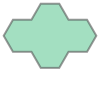

In [36]:
coordinates = [(0,1),(0,0),(1,0),(1,1)]
poligon = Polygon()
for pair in coordinates:
  x,y = createCellBinCorners(*pair)
  newpoligon = Polygon(zip(x,y))
  poligon = poligon.union(newpoligon)
poligon

In [37]:
def distance(point1,point2):
    return np.sqrt((point1[0]-point2[0])**2 + (point1[1]-point2[1])**2)

def remove_duplicates(points,tolerance=1e-7):
    unique_points = []
    for point in points:
        if all(distance(point,p)>tolerance for p in unique_points):
            unique_points.append(point)
    return unique_points

def unzip2(pairs):
    x = []; y = []
    for pair in pairs:
        x.append(pair[0])
        y.append(pair[1])
    return x,y

In [38]:
remove_duplicates(list (poligon.exterior.coords))

[(-2.5, 0.8660254037844386),
 (-1.9999999999999998, 1.7320508075688772),
 (-1.0, 1.7320508075688772),
 (-0.4999999999999998, 2.5980762113533156),
 (0.5000000000000001, 2.5980762113533156),
 (1.0, 1.732050807568877),
 (2.0, 1.7320508075688772),
 (2.5, 0.8660254037844385),
 (2.0, -1.1102230246251565e-16),
 (0.9999999999999999, 1.1102230246251557e-16),
 (0.5000000000000001, -0.8660254037844386),
 (-0.5000000000000004, -0.8660254037844384),
 (-0.9999999999999999, -9.042694559306846e-17),
 (-2.0000000000000004, 1.1102230246251565e-16)]

In [39]:
typecode = "MH-T"
typecodeFilter = cellDF["Typecode"] == typecode
calibFilter = (cellDF["ROCpin"] == "CALIB0") | (cellDF["ROCpin"] == "CALIB1")
NCfilter = cellDF["TrLink"]=='-1'

completeFilter = typecodeFilter & (~calibFilter) & ~NCfilter

TCPolys = {}
for cell in cellDF[completeFilter].itertuples():
    iu = int(cell.iu)
    iv = int(cell.iv)
    x,y = createCellBinCorners(iu,iv)
    poly = Polygon(list(zip(x,y)))
    trigLink=int(cell.TrLink)
    trigCell=int(cell.TrCell)
    ROC = int(cell.ROC)
    
    trigLink = trigLink//2 if typecode[1]=='H' else trigLink

    typecodeid = TCi.getIndexfromTypecode(typecode)
    trCellIdx = TCi.denseIndex(typecodeid,ROC,trigLink,trigCell)

    if trCellIdx not in TCPolys:
        TCPolys[trCellIdx] = Polygon()

    TCPolys[trCellIdx] = TCPolys[trCellIdx].union(poly)
    trCellIdList.add(trCellIdx)

TCCorners = {}
for trCellIdx in TCPolys:
    if type(TCPolys[trCellIdx]) == Polygon:
        TCCorners[trCellIdx] = (TCPolys[trCellIdx].exterior.coords)
    else:
        TCCorners[trCellIdx] = ([pt for poly in TCPolys[trCellIdx].geoms for pt in list(poly.exterior.coords)])

gr = ROOT.TH2Poly()
i=1
for trCellIdx in TCCorners:
    x,y = unzip2(TCCorners[trCellIdx])
    bins = ROOT.TGraph(len(x),np.array(x),np.array(y))
    gr.AddBin(bins)

    gr.SetBinContent(i,trCellIdx)
    i+=1


if ROOT.gROOT.FindObject("canvas"):
    ROOT.gROOT.FindObject("canvas").Close()
canvas = ROOT.TCanvas('canvas',"iu iv coord example",600,600)

gr.Draw()
canvas.Draw()
print(trCellIdList,len(trCellIdList))
print(cellDF[completeFilter]["ROC"].unique(),cellDF[completeFilter]["TrLink"].unique(),cellDF[completeFilter]["TrCell"].unique())



{np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)} 19
['0' '1' '2'] ['0' '2'] ['0' '2' '1' '3']
